# Behavioral analysis

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Set some default display parameters for plots and tables.

In [3]:
sns.set(style="ticks", context="paper",
        rc={"xtick.major.size": 3, "ytick.major.size": 3,
            "xtick.major.width": 1, "ytick.major.width": 1,
            "axes.linewidth": 1, "lines.linewidth": 1})
mpl.rcParams["savefig.dpi"] = 150
pd.set_option("display.precision", 3)

Load in the cached complete data file.

In [4]:
data = pd.read_csv("data/punch_data.csv").query("stim")
data_corr = data.query("correct").copy()
data_resp = data.query("answered").copy()

Remove between-subjects differences in median RT so that error bars on plots represent within-subject error on the effects of interest.

In [5]:
def remove_intercept_variance(x, group_median):
    return x - x.median() + group_median
data_corr.loc[:, "rt_within"] = data_corr.groupby("subj").rt.transform(remove_intercept_variance,
                                                                       data_corr.rt.median())

In [6]:
def savefig(fig, name):
    fig.savefig("figures/{}.pdf".format(name), dpi=300)
    fig.savefig("figures/{}.png".format(name), dpi=120)
    fig.savefig("tiffs/{}.tiff".format(name), dpi=300)

In [7]:
%load_ext rpy2.ipython
%R -n library(lme4)

/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Matrix

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [8]:
%%R
lr.test = function(m1, m2, name){
    print(summary(m1))
    out = anova(m1, m2)
    chi2 = out$Chisq[2]
    dof = out$"Chi Df"[2]
    p = out$"Pr(>Chisq)"[2]
    test_str = "\nLikelihood ratio test for %s:\n  Chisq(%d) = %.2f; p = %.3g"
    writeLines(sprintf(test_str, name, dof, chi2, p))
}

In [9]:
%%R -i data
data$log.cpe = log(data$pe_context)
data.corr = data[data$correct,]
data.corr$log.cpe = log(data.corr$pe_context)
data.resp = data[data$answered,]
data.resp$log.cpe = log(data.resp$pe_context)

## Basic statistics about the behavioral data

### Perceptual coherence of experimental stimuli

Summarize the average coherence (based on the actual signal that was acheived during stimulus presentation) for each context.

In [10]:
data.groupby("subj")[["color_signal", "motion_signal"]].mean().describe().T

,count,mean,std,min,25%,50%,75%,max
color_signal,15,0.18,0.06,0.1,0.15,0.16,0.18,0.36
motion_signal,15,0.25,0.10,0.1,0.17,0.23,0.32,0.48


### Response accuracy

In [11]:
pd.pivot_table(data_resp, "correct", "subj", "context").describe().T

,count,mean,std,min,25%,50%,75%,max
color,15,0.89,0.05,0.83,0.85,0.91,0.93,0.97
motion,15,0.87,0.08,0.76,0.80,0.86,0.93,0.98


In [12]:
%%R
m = glmer(correct ~ context + (context | subj), data.resp, family=binomial)
m.null = glmer(correct ~ 1 + (context | subj), data.resp, family=binomial)
lr.test(m, m.null, "main effect of context")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct ~ context + (context | subj)
   Data: data.resp

     AIC      BIC   logLik deviance df.resid 
  6180.4   6215.8  -3085.2   6170.4     8751 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.6914  0.2153  0.3084  0.4314  0.5610 

Random effects:
 Groups Name          Variance Std.Dev. Corr 
 subj   (Intercept)   0.2370   0.4869        
        contextmotion 0.6681   0.8174   -0.38
Number of obs: 8756, groups:  subj, 15

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)     2.2321     0.1367  16.333   <2e-16 ***
contextmotion  -0.1743     0.2242  -0.778    0.437    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
contextmotn -0.424

Likelihood ratio test for main effect of context:
  Chisq(1) = 0.58; p = 0.445


### Proportion missed trials

In [13]:
1 - data.answered.mean()

0.027111111111111086

### Effect of context on reaction time

In [14]:
pd.pivot_table(data_corr, "rt", "subj", "context").describe().T

,count,mean,std,min,25%,50%,75%,max
color,15,1.27,0.15,0.93,1.19,1.27,1.31,1.55
motion,15,1.20,0.21,0.74,1.10,1.17,1.36,1.57


In [15]:
%%R
m = lmer(rt ~ context + (context | subj), data.corr)
m.null = lmer(rt ~ 1 + (context | subj), data.corr)
lr.test(m, m.null, "main effect of context")

/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: refitting model(s) with ML (instead of REML)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ context + (context | subj)
   Data: data.corr

REML criterion at convergence: 2149.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6982 -0.7213 -0.0747  0.6567  3.5396 

Random effects:
 Groups   Name          Variance Std.Dev. Corr
 subj     (Intercept)   0.023685 0.15390      
          contextmotion 0.008625 0.09287  0.45
 Residual               0.076159 0.27597      
Number of obs: 7706, groups:  subj, 15

Fixed effects:
              Estimate Std. Error t value
(Intercept)    1.27249    0.03998   31.83
contextmotion -0.07203    0.02479   -2.91

Correlation of Fixed Effects:
            (Intr)
contextmotn 0.411 

Likelihood ratio test for main effect of context:
  Chisq(1) = 7.07; p = 0.00783


## Analyses of context prediction error

### Test to support using log(CPE)

In [16]:
%%R
m.lin = lmer(rt ~ pe_context + (pe_context | subj), data.corr)
m.log = lmer(rt ~ log.cpe + (log.cpe | subj), data.corr)
print(anova(m.lin, m.log))

Data: data.corr
Models:
m.lin: rt ~ pe_context + (pe_context | subj)
m.log: rt ~ log.cpe + (log.cpe | subj)
      Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
m.lin  6 2340.7 2382.4 -1164.3   2328.7                             
m.log  6 2323.8 2365.5 -1155.9   2311.8 16.928      0  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Main effect of log(CPE)

In [17]:
%%R
m = lmer(rt ~ log.cpe + (log.cpe | subj), data.corr)
m.null = lmer(rt ~ 1 + (log.cpe | subj), data.corr)
lr.test(m, m.null, "main effect of log(CPE)")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ log.cpe + (log.cpe | subj)
   Data: data.corr

REML criterion at convergence: 2323.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7391 -0.7389 -0.0813  0.6501  3.7294 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 subj     (Intercept) 0.029650 0.17219       
          log.cpe     0.001389 0.03726  -0.10
 Residual             0.078099 0.27946       
Number of obs: 7706, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.32021    0.04522  29.197
log.cpe      0.08338    0.01230   6.779

Correlation of Fixed Effects:
        (Intr)
log.cpe 0.028 

Likelihood ratio test for main effect of log(CPE):
  Chisq(1) = 21.89; p = 2.88e-06


In [18]:
%%R
m = lmer(rt ~ log.cpe + context_freq + (log.cpe + context_freq | subj), data.corr)
m.null = lmer(rt ~ context_freq + (log.cpe + context_freq | subj), data.corr)
lr.test(m, m.null, "main effect of log(CPE) controlling for context frequency")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ log.cpe + context_freq + (log.cpe + context_freq | subj)
   Data: data.corr

REML criterion at convergence: 2327.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7477 -0.7381 -0.0862  0.6513  3.7316 

Random effects:
 Groups   Name         Variance Std.Dev. Corr       
 subj     (Intercept)  0.029063 0.17048             
          log.cpe      0.000657 0.02563   0.02      
          context_freq 0.001133 0.03366   0.19 -0.98
 Residual              0.078089 0.27944             
Number of obs: 7706, groups:  subj, 15

Fixed effects:
              Estimate Std. Error t value
(Intercept)   1.320468   0.045205  29.210
log.cpe       0.082480   0.013498   6.111
context_freq -0.002014   0.026630  -0.076

Correlation of Fixed Effects:
            (Intr) log.cp
log.cpe      0.014       
context_frq -0.067  0.469

Likelihood ratio test for main effect of log(CPE) controlling for context frequency:
  Chisq(1) = 20.72; p = 5.

### Main effect of congruency

In [19]:
%%R
m = lmer(rt ~ congruent + log.cpe + (congruent + log.cpe | subj), data.corr)
m.null = lmer(rt ~ log.cpe + (congruent + log.cpe | subj), data.corr)
lr.test(m, m.null, "main effect of stimulus congruency")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ congruent + log.cpe + (congruent + log.cpe | subj)
   Data: data.corr

REML criterion at convergence: 2319.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7372 -0.7319 -0.0811  0.6591  3.6819 

Random effects:
 Groups   Name          Variance  Std.Dev. Corr       
 subj     (Intercept)   0.0283522 0.1684              
          congruentTRUE 0.0004795 0.0219    0.42      
          log.cpe       0.0013177 0.0363   -0.04 -0.71
 Residual               0.0779400 0.2792              
Number of obs: 7706, groups:  subj, 15

Fixed effects:
               Estimate Std. Error t value
(Intercept)    1.326064   0.044326  29.916
congruentTRUE -0.014440   0.008527  -1.693
log.cpe        0.082284   0.012108   6.796

Correlation of Fixed Effects:
            (Intr) cnTRUE
congrntTRUE  0.226       
log.cpe      0.073 -0.338

Likelihood ratio test for main effect of stimulus congruency:
  Chisq(1) = 2.77; p = 0.0958


### Interaction between log(CPE) and congruency

In [20]:
%%R
m = lmer(rt ~ congruent * log.cpe + (congruent * log.cpe | subj), data.corr)
m.null = lmer(rt ~ congruent + log.cpe + (congruent * log.cpe | subj), data.corr)
lr.test(m, m.null, "interaction between log(CPE) stimulus congruency")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ congruent * log.cpe + (congruent * log.cpe | subj)
   Data: data.corr

REML criterion at convergence: 2323.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7171 -0.7301 -0.0803  0.6573  3.6747 

Random effects:
 Groups   Name                  Variance  Std.Dev. Corr             
 subj     (Intercept)           0.0261345 0.16166                   
          congruentTRUE         0.0020521 0.04530   0.49            
          log.cpe               0.0019659 0.04434  -0.15 -0.80      
          congruentTRUE:log.cpe 0.0005535 0.02353   0.59  0.99 -0.78
 Residual                       0.0779189 0.27914                   
Number of obs: 7706, groups:  subj, 15

Fixed effects:
                       Estimate Std. Error t value
(Intercept)            1.321662   0.043210  30.587
congruentTRUE         -0.004866   0.020247  -0.240
log.cpe                0.077730   0.015597   4.984
congruentTRUE:log.cpe  0.009629   0.016491

### Effect of presenting context cue early

In [21]:
%%R
m = lmer(rt ~ early + (early | subj), data.corr)
m.null = lmer(rt ~ 1 + (early | subj), data.corr)
lr.test(m, m.null, "Main effect of early cue")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ early + (early | subj)
   Data: data.corr

REML criterion at convergence: 1692.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3710 -0.7239 -0.0881  0.6373  3.6658 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 subj     (Intercept) 0.030924 0.17585       
          earlyTRUE   0.006932 0.08326  -0.03
 Residual             0.071727 0.26782       
Number of obs: 7706, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.31694    0.04561  28.872
earlyTRUE   -0.15738    0.02235  -7.042

Correlation of Fixed Effects:
          (Intr)
earlyTRUE -0.044

Likelihood ratio test for Main effect of early cue:
  Chisq(1) = 22.71; p = 1.89e-06


### Interaction of log(CPE) effect with cue timing manipulation

In [22]:
%%R
m = lmer(rt ~ log.cpe * early + (log.cpe * early | subj), data.corr)
m.null = lmer(rt ~ log.cpe + early + (log.cpe * early | subj), data.corr)
lr.test(m, m.null, "interaction between log(CPE) and early cue")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ log.cpe * early + (log.cpe * early | subj)
   Data: data.corr

REML criterion at convergence: 1518.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1219 -0.7222 -0.0889  0.6326  3.6499 

Random effects:
 Groups   Name              Variance  Std.Dev. Corr             
 subj     (Intercept)       0.0226173 0.15039                   
          log.cpe           0.0016605 0.04075  -0.55            
          earlyTRUE         0.0108059 0.10395   0.24  0.02      
          log.cpe:earlyTRUE 0.0009251 0.03042   0.75 -0.56  0.76
 Residual                   0.0699290 0.26444                   
Number of obs: 7706, groups:  subj, 15

Fixed effects:
                  Estimate Std. Error t value
(Intercept)        1.43695    0.04049   35.49
log.cpe            0.11913    0.01490    8.00
earlyTRUE         -0.21244    0.03106   -6.84
log.cpe:earlyTRUE -0.05282    0.01650   -3.20

Correlation of Fixed Effects:
            (Intr

### Main effect of log(CPE) on early trials

In [23]:
%%R
m = lmer(rt ~ log.cpe + (log.cpe | subj), data.corr, subset=early)
m.null = lmer(rt ~ 1 + (log.cpe | subj), data.corr, subset=early)
lr.test(m, m.null, "main effect of log(CPE) on early cue trials")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ log.cpe + (log.cpe | subj)
   Data: data.corr
 Subset: early

REML criterion at convergence: 959.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6291 -0.7064 -0.1222  0.6053  3.5183 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr
 subj     (Intercept) 0.0405214 0.20130      
          log.cpe     0.0007233 0.02689  0.38
 Residual             0.0732255 0.27060      
Number of obs: 3898, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.22452    0.05310  23.060
log.cpe      0.06649    0.01236   5.382

Correlation of Fixed Effects:
        (Intr)
log.cpe 0.364 

Likelihood ratio test for main effect of log(CPE) on early cue trials:
  Chisq(1) = 16.86; p = 4.03e-05


### Main effect of log(CPE) on context repeat trials

In [24]:
%%R
m = lmer(rt ~ log.cpe + (log.cpe | subj), data.corr, subset=!context_switch)
m.null = lmer(rt ~ 1 + (log.cpe | subj), data.corr, subset=!context_switch)
lr.test(m, m.null, "main effect of log(CPE) on context repeat trials")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ log.cpe + (log.cpe | subj)
   Data: data.corr
 Subset: !context_switch

REML criterion at convergence: 1188.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7846 -0.7363 -0.0927  0.6446  3.5860 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 subj     (Intercept) 0.0300518 0.17335       
          log.cpe     0.0005138 0.02267  -0.46
 Residual             0.0747662 0.27343       
Number of obs: 4507, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.28630    0.04658  27.618
log.cpe      0.06905    0.01202   5.746

Correlation of Fixed Effects:
        (Intr)
log.cpe 0.015 

Likelihood ratio test for main effect of log(CPE) on context repeat trials:
  Chisq(1) = 18.21; p = 1.98e-05


### Main effect of log(CPE) on context switch trials

In [25]:
%%R
m = lmer(rt ~ log.cpe + (log.cpe | subj), data.corr, subset=context_switch)
m.null = lmer(rt ~ 1 + (log.cpe | subj), data.corr, subset=context_switch)
lr.test(m, m.null, "main effect of log(CPE) on context switch trials")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ log.cpe + (log.cpe | subj)
   Data: data.corr
 Subset: context_switch

REML criterion at convergence: 1117.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7475 -0.7378 -0.0615  0.6737  3.5047 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 subj     (Intercept) 0.036993 0.19233      
          log.cpe     0.002425 0.04924  0.64
 Residual             0.080976 0.28456      
Number of obs: 3199, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.29422    0.05127  25.246
log.cpe      0.01655    0.02010   0.823

Correlation of Fixed Effects:
        (Intr)
log.cpe 0.568 

Likelihood ratio test for main effect of log(CPE) on context switch trials:
  Chisq(1) = 0.71; p = 0.399


### Interaction with context switch events

In [26]:
%%R
m = lmer(rt ~ log.cpe * context_switch + (log.cpe * context_switch | subj), data.corr)
m.null = lmer(rt ~ log.cpe + context_switch + (log.cpe * context_switch | subj), data.corr)
lr.test(m, m.null, "interaction between log(CPE) and context switches")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ log.cpe * context_switch + (log.cpe * context_switch | subj)
   Data: data.corr

REML criterion at convergence: 2259.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7349 -0.7371 -0.0800  0.6576  3.6092 

Random effects:
 Groups   Name                       Variance Std.Dev. Corr             
 subj     (Intercept)                0.030488 0.17461                   
          log.cpe                    0.000699 0.02644  -0.33            
          context_switchTRUE         0.003813 0.06175   0.14 -0.06      
          log.cpe:context_switchTRUE 0.003751 0.06125   0.44 -0.36  0.93
 Residual                            0.077259 0.27796                   
Number of obs: 7706, groups:  subj, 15

Fixed effects:
                            Estimate Std. Error t value
(Intercept)                 1.286064   0.046944  27.396
log.cpe                     0.068924   0.012665   5.442
context_switchTRUE          0.007775   0.024

### Main behavioral figure

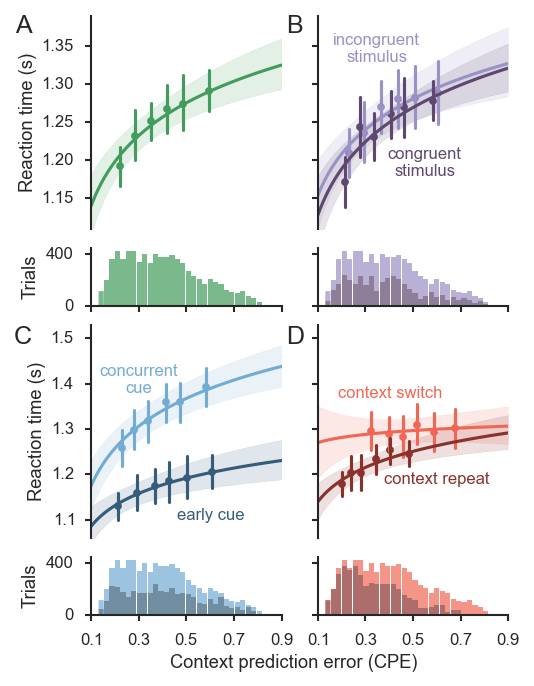

In [27]:
f = plt.figure(figsize=(3.5, 4.5))

reg_axes = []
hist_axes = []
gs = plt.GridSpec(8, 2)

# Make it easy to switch to black and white if necessary
black_and_white = False
if black_and_white:
    pe_color = ".25"
    congr_pal = [".1", ".4"]
    early_pal = [".1", ".4"]
    switch_pal = [".1", ".4"]
else:
    pe_color = "#429c5c"
    congr_pal = ["#5f486f", "#9a91c4"]
    early_pal = ["#355d7a", "#72acd3"]
    switch_pal = ["#8b312d", "#f06855"]

# Initialize the subplot axes
for row in range(2):
    for col in range(2):

        rr = slice(row * 4, row * 4 + 3)
        hr = row * 4 + 3
        reg_axes.append(f.add_subplot(gs[rr, col]))
        hist_axes.append(f.add_subplot(gs[hr, col]))

        if col:
            reg_axes[-1].set(yticklabels=[])
            hist_axes[-1].set(yticklabels=[])

        if row:
            reg_axes[-1].set(xlim=(.1, .9), ylim=(1.06, 1.53))
        else:
            reg_axes[-1].set(xticklabels=[])
            hist_axes[-1].set(xticklabels=[])
            reg_axes[-1].set(xlim=(.1, .9), ylim=(1.11, 1.39))
        hist_axes[-1].set(xlim=(.1, .9), ylim=(0, 450))

# Set some keyword arguments that will be shared across subplots
bins = np.percentile(data_corr.pe_context, [10, 30, 50, 70, 90])
bins = 6
reg_kws = dict(x_bins=bins, units="subj", n_boot=10000, logx=True,
               scatter_kws={"s": 12}, line_kws={"lw": 1.5})

hist_kws = dict(bins=30, rwidth=.95, alpha=.7, linewidth=0)
text_kws = dict(ha="center", size=8)

# ===================================================================================
# Plot showing the relationship between log(CPE) and RT

sns.regplot("pe_context", "rt_within", data_corr, ax=reg_axes[0], color=pe_color, **reg_kws)
hist_axes[0].hist(data_corr.pe_context, color=pe_color, **hist_kws)

# -----------------------------------------------------------------------------------
# Plot showing the (non) effect of incongruent stimuli

sns.regplot("pe_context", "rt_within", data_corr.query("not congruent"),
            ax=reg_axes[1], color=congr_pal[1], **reg_kws)
sns.regplot("pe_context", "rt_within", data_corr.query("congruent"),
            ax=reg_axes[1], color=congr_pal[0], **reg_kws)
hist_axes[1].hist([data_corr.query("congruent").pe_context,
                   data_corr.query("not congruent").pe_context],
                  histtype="barstacked", color=congr_pal, **hist_kws)
reg_axes[1].text(.55, 1.18, "congruent\nstimulus", color=congr_pal[0], **text_kws)
reg_axes[1].text(.35, 1.33, "incongruent\nstimulus", color=congr_pal[1], **text_kws)

# -----------------------------------------------------------------------------------
# Plot showing the interaction between log(CPE) and early cue presentation

sns.regplot("pe_context", "rt_within", data_corr.query("early"),
            ax=reg_axes[2], color=early_pal[0], **reg_kws)
sns.regplot("pe_context", "rt_within", data_corr.query("not early"),
            ax=reg_axes[2], color=early_pal[1], **reg_kws)
hist_axes[2].hist([data_corr.query("early").pe_context,
                   data_corr.query("not early").pe_context],
                  histtype="barstacked", color=early_pal, **hist_kws)
reg_axes[2].text(.6, 1.10, "early cue", color=early_pal[0], **text_kws)
reg_axes[2].text(.3, 1.38, "concurrent\ncue", color=early_pal[1], **text_kws)

# -----------------------------------------------------------------------------------
# Plot showing the interaction between log(CPE) and context switch trials

sns.regplot("pe_context", "rt_within", data_corr.query("context_switch"),
            ax=reg_axes[3], color=switch_pal[1], **reg_kws)
sns.regplot("pe_context", "rt_within", data_corr.query("not context_switch"),
            ax=reg_axes[3], color=switch_pal[0], **reg_kws)
hist_axes[3].hist([data_corr.query("not context_switch").pe_context,
                   data_corr.query("context_switch").pe_context],
                  histtype="barstacked", color=switch_pal, **hist_kws)
reg_axes[3].text(.6, 1.18, "context repeat", color=switch_pal[0], **text_kws)
reg_axes[3].text(.4, 1.37, "context switch", color=switch_pal[1], **text_kws)

# ===================================================================================
# Tweak the labels and positioning of the figure

for i in range(4):
    reg_axes[i].set(xlabel="")
    if i % 2:
        reg_axes[i].set(ylabel="")
        hist_axes[i].set(ylabel="")
    else:
        reg_axes[i].set_ylabel("Reaction time (s)", labelpad=3)
        hist_axes[i].set_ylabel("Trials", labelpad=3)

[ax.set(xticks=[.1, .3, .5, .7, .9], yticks=[0, 400]) for ax in hist_axes]
sns.despine()
[sns.despine(ax=ax, bottom=True) for ax in reg_axes]
[ax.set(xticks=[]) for ax in reg_axes]

# Errorbar width isn't configurable in seaborn but default is too wide
for ax in reg_axes:
    for line in ax.lines:
        line.set_linewidth(1.5)

# Label the panels
f.text(.55, .02, "Context prediction error (CPE)", ha="center", size=8.8)
f.text(.02, .96, "A", size=12)
f.text(.54, .96, "B", size=12)
f.text(.02, .50, "C", size=12)
f.text(.54, .50, "D", size=12)

f.tight_layout(pad=.5, w_pad=.75, rect=[0.01, .03, 1, 1])
savefig(f, "behavioral_main")

----

## Tests of other variables that might influence RT

In [28]:
%%R
m = lmer(rt ~ context_switch + (context_switch | subj), data.corr)
m.null = lmer(rt ~ 1 + (context_switch | subj), data.corr)
lr.test(m, m.null, "main effect of context switch")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ context_switch + (context_switch | subj)
   Data: data.corr

REML criterion at convergence: 2301

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7801 -0.7348 -0.0760  0.6609  3.6474 

Random effects:
 Groups   Name               Variance  Std.Dev. Corr 
 subj     (Intercept)        0.0349269 0.18689       
          context_switchTRUE 0.0009234 0.03039  -0.59
 Residual                    0.0778957 0.27910       
Number of obs: 7706, groups:  subj, 15

Fixed effects:
                   Estimate Std. Error t value
(Intercept)         1.20586    0.04843  24.897
context_switchTRUE  0.07594    0.01016   7.471

Correlation of Fixed Effects:
            (Intr)
cntxt_sTRUE -0.488

Likelihood ratio test for main effect of context switch:
  Chisq(1) = 24.09; p = 9.18e-07


In [29]:
%%R
m = lmer(rt ~ frame_switch + (frame_switch | subj), data.corr, subset=!context_switch)
m.null = lmer(rt ~ 1 + (frame_switch | subj), data.corr, subset=!context_switch)
lr.test(m, m.null, "main effect of cue switch on repeat trials")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ frame_switch + (frame_switch | subj)
   Data: data.corr
 Subset: !context_switch

REML criterion at convergence: 1229.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8383 -0.7399 -0.0929  0.6545  3.6685 

Random effects:
 Groups   Name             Variance  Std.Dev. Corr 
 subj     (Intercept)      3.548e-02 0.188357      
          frame_switchTRUE 7.151e-06 0.002674 -1.00
 Residual                  7.549e-02 0.274761      
Number of obs: 4507, groups:  subj, 15

Fixed effects:
                 Estimate Std. Error t value
(Intercept)      1.197253   0.049004  24.432
frame_switchTRUE 0.016215   0.008237   1.968

Correlation of Fixed Effects:
            (Intr)
frm_swtTRUE -0.173

Likelihood ratio test for main effect of cue switch on repeat trials:
  Chisq(1) = 3.85; p = 0.0497


In [30]:
%%R
m = lmer(rt ~ evidence_switch + (evidence_switch | subj), data.corr, subset=!context_switch)
m.null = lmer(rt ~ 1 + (evidence_switch | subj), data.corr, subset=!context_switch)
lr.test(m, m.null, "main effect of evidence switch on repeat trials")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ evidence_switch + (evidence_switch | subj)
   Data: data.corr
 Subset: !context_switch

REML criterion at convergence: 1224.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8847 -0.7327 -0.0846  0.6539  3.6780 

Random effects:
 Groups   Name                Variance Std.Dev. Corr 
 subj     (Intercept)         0.038959 0.19738       
          evidence_switchTrue 0.000915 0.03025  -0.64
 Residual                     0.075305 0.27442       
Number of obs: 4507, groups:  subj, 15

Fixed effects:
                    Estimate Std. Error t value
(Intercept)          1.21384    0.05133  23.647
evidence_switchTrue -0.01402    0.01135  -1.235

Correlation of Fixed Effects:
            (Intr)
evdnc_swtcT -0.504

Likelihood ratio test for main effect of evidence switch on repeat trials:
  Chisq(1) = 1.56; p = 0.212


In [31]:
%%R
m = lmer(rt ~ response_switch + (response_switch | subj), data.corr, subset=response_switch != "nan")
m.null = lmer(rt ~ 1 + (response_switch | subj), data.corr, subset=response_switch != "nan")
lr.test(m, m.null, "main effect of response switch")

Linear mixed model fit by REML ['lmerMod']
Formula: rt ~ response_switch + (response_switch | subj)
   Data: data.corr
 Subset: response_switch != "nan"

REML criterion at convergence: 2382.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8901 -0.7400 -0.0821  0.6671  3.7838 

Random effects:
 Groups   Name                Variance  Std.Dev. Corr 
 subj     (Intercept)         0.0330810 0.1819        
          response_switchTrue 0.0001848 0.0136   -0.28
 Residual                     0.0791966 0.2814        
Number of obs: 7577, groups:  subj, 15

Fixed effects:
                     Estimate Std. Error t value
(Intercept)          1.247506   0.047188  26.437
response_switchTrue -0.018109   0.007367  -2.458

Correlation of Fixed Effects:
            (Intr)
rspns_swtcT -0.195

Likelihood ratio test for main effect of response switch:
  Chisq(1) = 5.36; p = 0.0207


## Supplemental behavioral figure

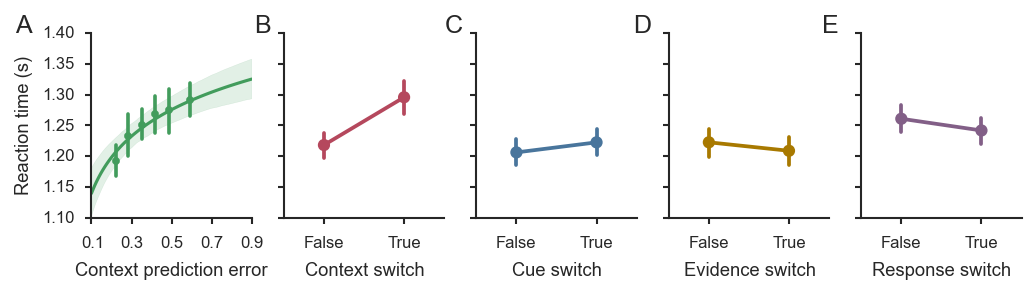

In [32]:
with sns.plotting_context({"lines.linewidth": .3}):
    f, axes = plt.subplots(1, 5, figsize=(7, 2), sharey=True)
sns.despine()

reg_kws = dict(units="subj", logx=True, scatter_kws={"s": 12}, line_kws={"lw": 1.5})
point_kws = dict(units="subj", n_boot=10000, order=[False, True])

# ===================================================================================
# Reproduce panel a from the main figure

axes[0].set(xlim=(.1, .9))
sns.regplot("pe_context", "rt_within", data_corr, color="#429c5c", x_bins=6, ax=axes[0], **reg_kws)
axes[0].set(xlabel="Context prediction error", xticks=[.1, .3, .5, .7, .9])

# -----------------------------------------------------------------------------------
# Show the main effect of context switches

sns.pointplot("context_switch", "rt_within", data=data_corr,
              color=sns.xkcd_rgb["dark rose"], ax=axes[1], **point_kws)
axes[1].set(xlabel="Context switch")

# -----------------------------------------------------------------------------------
# Show the main effect of cue switches, only on repeat trials

# Remove across subject intercept variance for just repeat trials 
data_repeat = data_corr[~data_corr.context_switch].copy()
data_repeat["rt_within"] = data_repeat.groupby("subj").rt.transform(remove_intercept_variance,
                                                                    data_repeat.rt.median())
sns.pointplot("frame_switch", "rt_within", data=data_repeat,
              color=sns.xkcd_rgb["dull blue"], ax=axes[2], **point_kws)
axes[2].set(xlabel="Cue switch")

# -----------------------------------------------------------------------------------
# Show the main effect of stimulus congruency

sns.pointplot("evidence_switch", "rt_within", data=data_repeat,
              color=sns.xkcd_rgb["bronze"], ax=axes[3], **point_kws)
axes[3].set(xlabel="Evidence switch")

# ===================================================================================

# -----------------------------------------------------------------------------------
# Show the main effect of response switches
sns.pointplot("response_switch", "rt_within", data=data_corr[~data_corr.response_switch.isnull()],
              color=sns.xkcd_rgb["dusty purple"], ax=axes[4], **point_kws)
axes[4].set(xlabel="Response switch")

axes[0].set_ylim(1.1, 1.4001)

start = .02
panels = list("ABCDE")
for i, ax in enumerate(axes):
    ax.set_ylabel("" if i else "Reaction time (s)")
    f.text(start + (bool(i) * .05) + (i * .18), .9, panels[i], size=12)
        
f.tight_layout(w_pad=.3)
savefig(f, "behavioral_supplement")

## Relationship between response accuracy and CPE

### Main effect of log(CPE)

In [33]:
%%R
m = glmer(correct ~ log.cpe + (log.cpe | subj), data.resp, family=binomial)
m.null = glmer(correct ~ 1 + (log.cpe | subj), data.resp, family=binomial)
lr.test(m, m.null, "main effect of log(CPE)")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct ~ log.cpe + (log.cpe | subj)
   Data: data.resp

     AIC      BIC   logLik deviance df.resid 
  6266.1   6301.5  -3128.0   6256.1     8751 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.5789  0.2603  0.3424  0.4222  0.5109 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 subj   (Intercept) 0.07904  0.2811        
        log.cpe     0.05183  0.2277   -1.00
Number of obs: 8756, groups:  subj, 15

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.7592     0.1148  15.329  < 2e-16 ***
log.cpe      -0.3380     0.1059  -3.193  0.00141 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
log.cpe 0.238 

Likelihood ratio test for main effect of log(CPE):
  Chisq(1) = 9.75; p = 0.00179


In [34]:
q = data_resp.pe_context.quantile(np.linspace(0, 1, 6))
data_resp.groupby(pd.cut(data_resp.pe_context, q)).correct.mean()

pe_context
(0.132, 0.251]    0.89
(0.251, 0.343]    0.89
(0.343, 0.436]    0.89
(0.436, 0.547]    0.86
(0.547, 0.817]    0.87
Name: correct, dtype: float64

### Interaction between congruency and log(CPE)

In [35]:
%%R
m = glmer(correct ~ log.cpe * congruent + (log.cpe | subj) + (congruent | subj),
          data.resp, family=binomial,
          control=glmerControl(optimizer="bobyqa"))
m.null = glmer(correct ~ log.cpe + congruent + (log.cpe | subj) + (congruent | subj),
               data.resp, family=binomial,
               control=glmerControl(optimizer="bobyqa"))
lr.test(m, m.null, "interaction between log(CPE) and congruency")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct ~ log.cpe * congruent + (log.cpe | subj) + (congruent |  
    subj)
   Data: data.resp
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
  6235.8   6306.6  -3107.9   6215.8     8746 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.3426  0.2603  0.3307  0.4161  0.6162 

Random effects:
 Groups Name          Variance Std.Dev. Corr 
 subj   (Intercept)   0.07324  0.2706        
        log.cpe       0.05756  0.2399   -1.00
 subj.1 (Intercept)   0.03066  0.1751        
        congruentTRUE 0.12096  0.3478   -1.00
Number of obs: 8756, groups:  subj, 15

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)             1.5226     0.1383  11.007  < 2e-16 ***
log.cpe                -0.4527     0.1280  -3.536 0.000406 ***
congruentTRUE           0.6555     0.1980  

### Main effect of log(CPE) on congruent trials

In [36]:
%%R
m = glmer(correct ~ log.cpe + (log.cpe | subj),
          data.resp, subset=congruent, family=binomial, 
          control=glmerControl(optimizer="bobyqa"))
m.null = glmer(correct ~ 1 + (log.cpe | subj),
               data.resp, subset=congruent, family=binomial,
               control=glmerControl(optimizer="bobyqa"))
lr.test(m, m.null, "main effect of log(CPE) on congruent trials")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct ~ log.cpe + (log.cpe | subj)
   Data: data.resp
Control: glmerControl(optimizer = "bobyqa")
 Subset: congruent

     AIC      BIC   logLik deviance df.resid 
  2632.2   2663.8  -1311.1   2622.2     4083 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7659  0.2885  0.3173  0.3561  0.4423 

Random effects:
 Groups Name        Variance  Std.Dev. Corr 
 subj   (Intercept) 2.526e-01 0.502545      
        log.cpe     9.379e-05 0.009684 -1.00
Number of obs: 4088, groups:  subj, 15

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.24793    0.19917  11.286   <2e-16 ***
log.cpe     -0.03642    0.13794  -0.264    0.792    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr)
log.cpe 0.689 

Likelihood ratio test for main effect of log(CPE) on congru

### Interaction of early cue and congruent trials

In [37]:
%%R
m = glmer(correct ~ early * congruent + (early | subj) + (congruent | subj),
          data.resp, family=binomial,
          control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=50000)))
m.null = glmer(correct ~ early + congruent + (early | subj) + (congruent | subj),
               data.resp, family=binomial,
               control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=50000)))
lr.test(m, m.null, "interaction of early cue and congruent trials")

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: correct ~ early * congruent + (early | subj) + (congruent | subj)
   Data: data.resp
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 50000))

     AIC      BIC   logLik deviance df.resid 
  6241.6   6312.4  -3110.8   6221.6     8746 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.5018  0.2526  0.3237  0.4106  0.6292 

Random effects:
 Groups Name          Variance Std.Dev. Corr 
 subj   (Intercept)   0.10044  0.3169        
        earlyTRUE     0.08103  0.2847   -0.02
 subj.1 (Intercept)   0.18411  0.4291        
        congruentTRUE 0.10630  0.3260   -0.63
Number of obs: 8756, groups:  subj, 15

Fixed effects:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)               1.8465     0.1512  12.209  < 2e-16 ***
earlyTRUE                 0.2161     0.1172   1.844 0.065132 .  
congruentTRUE  